In [1]:
import warnings
import math
import numpy as np # to use numpy arrays instead of lists
import pandas as pd # DataFrame (table)
import matplotlib.pyplot as plt # to plot
from sklearn.model_selection import train_test_split
import sklearn.decomposition as sk # to compute PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [2]:
def main():
    warnings.filterwarnings("ignore")

    datos = leeDatos()
    #print(datos)

    estados = ['Nacional', 'MEXICO', 'DISTRITO FEDERAL', 'GUANAJUATO', 'JALISCO', 'MORELOS','PUEBLA','QUERETARO']
    misDatos = datos[estados]
    print(datos[estados])

    graficaDatos(misDatos.iloc[0:290,:])

    datosLin = linealizar(misDatos.iloc[0:290,:])

    graficaDatos(datosLin)

    computeCorr(datosLin)

    num_comp = 3
    preprocessData = computePCA(datosLin, num_comp=num_comp)

    graficaDatos(preprocessData)
    print("\n")

    ts_size = .25
    [trainSet, testSet] = splitDataSet(preprocessData, test_size=ts_size, randSplit=False)

    [trainModel, testModel] = metodosML(trainSet, testSet)

    graficaDatos(trainModel)
    graficaDatos(testModel)


def leeDatos():

    dataSet = pd.read_csv("gdrive/MyDrive/Colab Notebooks/covid.csv", header=0, index_col=0)
    dataSet.index = pd.to_datetime(dataSet.index,format='%d/%m/%y',errors='ignore')

    return dataSet

def graficaDatos(dataSet=0):

    plt.figure()
    for i in range(len(dataSet.columns)):
        plt.plot(dataSet.iloc[:,i],label=dataSet.columns[i],marker=i+2,markevery=150)
    plt.grid(color='b',linestyle='dashed')
    plt.gcf().autofmt_xdate()
    plt.title('COVID-19', fontweight='bold')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.legend(loc='upper left')
    plt.show()

def linealizar(dataSet=0):
    """
    Normalize and smooth data
    """
    dataSet = dataSet.fillna(method='ffill')

    # computing range of data for the regressions
    size = len(dataSet)
    x = range(size)
    numFeatures = len(dataSet.columns)

    for i in range(numFeatures):
        dataSet.iloc[:,i] = dataSet.iloc[:,i]  / dataSet.iloc[:,i].abs().max()
        polyCoef = np.polyfit(x, dataSet.iloc[:,i], 3)   # coefficients 10
        regModel = np.poly1d(polyCoef)              # equation
        regSpace = np.linspace(1, size, size)          # generate n numbers between a range
        dataSet.iloc[:,i] = regModel(regSpace)

    return dataSet

# compute PCA
def computeCorr(dataSet):
    """
    Compute CORRELATION
    """

    # correlation analysis
    correlation=dataSet.corr(method = 'pearson')
    print("==========================================================")
    print("                 CORRELATION ANALYSIS")
    print("----------------------------------------------------------")
    print(correlation)
    print("\n")


# compute PCA
def computePCA(dataSet, num_comp=3):
    """
    Compute PCA
    """
    features = dataSet
    features = features.drop([dataSet.columns[0]], axis=1)

    pca = sk.PCA(n_components=num_comp)
    principalComponents = pca.fit_transform(features)
    comp_names = ['P. Comp. {}'.format(i+1) for i in range(num_comp)]
    principalComp = pd.DataFrame(data = principalComponents.tolist(),
                                 columns = comp_names)
    principalComp.set_index(dataSet.index,inplace = True, drop=True)
    principalComp[dataSet.columns[0]] = dataSet[dataSet.columns[0]]
    cols = [dataSet.columns[0]] + sorted(comp_names)
    principalComp = principalComp[cols]
    print("==========================================================")
    print("                 PCA ANALYSIS")
    print("----------------------------------------------------------")
    print(principalComp)
    print("\n")

    # explained variance ratio
    varRatio = (pca.explained_variance_ratio_)*100
    dic = {'P. Comp. {}'.format(i+1): varRatio[i] for i in range(num_comp)}
    expVar = pd.DataFrame(dic, index=['Exp Var Ratio %'])

    # Principal axes in feature space, representing the directions of maximum variance
    # get the index of the most important feature on EACH component
    # LIST COMPREHENSION HERE
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(num_comp)]
    # get the names
    initial_feature_names = features.columns
    most_important_names = [initial_feature_names[most_important[i]] for i in range(num_comp)]
    # complete the dataframe
    # LIST COMPREHENSION HERE AGAIN
    dic = {'P. Comp. {}'.format(i+1): most_important_names[i] for i in range(num_comp)}
    #df = pd.DataFrame(dic.items()).T
    expVar = pd.concat([expVar, pd.DataFrame(dic, index =['Most Imp. F.'])])
    print(expVar)
    print("\n")

    return principalComp

# --------------------
# split data
def splitDataSet(dataSet=0, test_size=.2, randSplit=True):
    """
    Split data in train and test sets
    """

    train, test = train_test_split(dataSet, test_size=test_size, shuffle=randSplit)

    return [train, test]

In [3]:
def metodosML(dataSet=0, dataSet2=0):

    methodsUsed=['RF', 'SVM']
    performanceHeaders=['RSS','SSR','TSS','R-Square','Adj. R-Square', 'AIC', 'APC', 'BIC']
    comperrHeaders=['MSE','RMSE', 'MAPE']
    errorHeaders=['Mean','Median', 'SD','25%','50%','75%','Min','Max','Range']
    modPerformance = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance.index.name = "Model Performance"
    comperr = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr.index.name = "Error Metrics"
    regError = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError.index.name = "Relative Error"
    modPerformance3 = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance3.index.name = "Model Performance"
    comperr3 = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr3.index.name = "Error Metrics"
    regError3 = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError3.index.name = "Relative Error"

    trainModel = pd.DataFrame()
    testModel = pd.DataFrame()
    yModel = pd.DataFrame()
    yModel3 = pd.DataFrame()
    trainModel['Raw Data'] = dataSet.iloc[:,0]
    testModel['Raw Data'] = dataSet2.iloc[:,0]
    sizeData=len(dataSet.columns)-1

    n = []
    calc = 2
    while calc < 16:
      n.append(calc)
      calc += 1

    param_grid = {
      'n_estimators': n,
      'max_depth': n  #[2, 3, 4, 5, 6, 7, 8]
    }

    reg = RandomForestRegressor()
    grid_search = GridSearchCV(reg, param_grid, verbose=1)
    grid_search.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))

    print("RF Estimated Parameters:")
    print("Best parameters found: ", grid_search.best_params_)
    #print(grid_search.best_params_['n_estimators'])
    #print(grid_search.best_params_['max_depth'])
    print("Best cross-validation score: ", grid_search.best_score_)
    print("\n")

    # Random Forest
    regr = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'])
    regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted RF'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted RF'] = trainModel['Fitted RF']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'RF', dataSet, 0, regError, comperr, modPerformance, 0)
    # test data
    testModel['Fitted RF'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted RF'] = testModel['Fitted RF']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'RF', dataSet2, 0, regError3, comperr3, modPerformance3, 0)
    print("RF Parameters:")
    print(f"Number of trees (n_estimators): {regr.n_estimators}")
    print(f"Max depth of trees (max_depth): {regr.max_depth}")
    print("\n")


    param_grid = {
      'kernel': ['poly', "rbf", 'sigmoid'],
      'degree': n,
      'coef0': [1]
    }

    reg = svm.SVR()
    grid_search = GridSearchCV(reg, param_grid, verbose=1)
    grid_search.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))

    print("SVM Estimated Parameters:")
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    print("\n")

    # SVM regression
    regr = svm.SVR(kernel="poly", degree=grid_search.best_params_['degree'], coef0=grid_search.best_params_['coef0'])
    regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted SVM'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted SVM'] = trainModel['Fitted SVM']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'SVM', dataSet, 0, regError, comperr, modPerformance, 1)
    # test data
    testModel['Fitted SVM'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted SVM'] = testModel['Fitted SVM']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'SVM', dataSet2, 0, regError3, comperr3, modPerformance3, 1)


    print("=======================================================================")
    print("                      MODEL PERFORMANCE COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(modPerformance.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print("-----------------------------------------------------------------------")
    print(modPerformance3.T)
    print("=======================================================================")
    print("                      ERROR METRICS")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(comperr.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print(comperr3.T)
    print("=======================================================================")
    print("                      MAPE (RELATIVE ERROR) COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(regError.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print("-----------------------------------------------------------------------")
    print(regError3.T)
    print("\n")

    plt.figure()
    plt.plot(yModel3['Fitted RF'], yModel3['Residuals RF'],'o', color='g',label='Residuals')
    plt.grid(color='b',linestyle='dashed')
    plt.axhline(y=0, color='red')
    plt.title("RF Model Residuals", fontweight='bold')
    plt.xlabel('Predictor')
    plt.ylabel('Residuals')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    plt.plot(yModel3['Rel Error RF'], color='orange',label='Relative Error', linestyle='--')
    plt.grid(color='b',linestyle='dashed')
    plt.gcf().autofmt_xdate()
    #plt.margins(x=-.4, y=-0.15)
    plt.title('MAPE RF', fontweight='bold')
    plt.xlabel('Value')
    plt.ylabel('Date (t)')
    plt.legend(loc='upper right')
    plt.show()

    return [trainModel, testModel]

# --------------------
# create performance tables
def compareMethod(yModel, method, dataSet, y, regError, comperr, modPerformance, i):
    name_fit = 'Fitted ' + method
    name_res = 'Residuals ' + method
    name_err = 'Rel Error ' + method

    size = len(yModel)

    # compute residuals and relative error
    yModel[name_res] = dataSet.iloc[:,y] - yModel[name_fit]
    yModel[name_err] = (1-(yModel[name_fit]/dataSet.iloc[:,y])).abs()
    regError.iloc[i,0] = yModel[name_err].mean(axis=0)
    regError.iloc[i,1] = yModel[name_err].median(axis=0)
    regError.iloc[i,2] = yModel[name_err].std(axis=0)
    regError.iloc[i,3] = yModel[name_err].quantile(q=.25)
    regError.iloc[i,4] = yModel[name_err].quantile(q=.5)
    regError.iloc[i,5] = yModel[name_err].quantile(q=.75)
    regError.iloc[i,6] = yModel[name_err].min()
    regError.iloc[i,7] = yModel[name_err].max()
    regError.iloc[i,8] = regError.iloc[i,7] - regError.iloc[i,6]

    # Models Performance
    modPerformance.iloc[i,0] = (yModel[name_res]**2).sum()
    modPerformance.iloc[i,1] = ((yModel[name_fit]-dataSet.iloc[:,y].mean(axis=0))**2).sum()
    modPerformance.iloc[i,2] = modPerformance.iloc[i,0]+modPerformance.iloc[i,1]
    modPerformance.iloc[i,3] = 1-modPerformance.iloc[i,0]/modPerformance.iloc[i,2]
    modPerformance.iloc[i,4] = 1-(1-modPerformance.iloc[i,3])*((size-1)/(size-4-1))
    modPerformance.iloc[i,5] = 4*math.log(size)+size*math.log(modPerformance.iloc[i,0]/size)
    modPerformance.iloc[i,6] = 4*2/size+math.log(modPerformance.iloc[i,0])
    modPerformance.iloc[i,7] = 4*2+size*math.log(modPerformance.iloc[i,0]/size)

    # error metrics
    comperr.iloc[i,0] = modPerformance.iloc[i,0]/size
    comperr.iloc[i,1] = comperr.iloc[i,0]**(1/2)
    comperr.iloc[i,2] = regError.iloc[i,0]

    return (yModel, regError, comperr, modPerformance)

            Nacional  MEXICO  DISTRITO FEDERAL  GUANAJUATO  JALISCO  MORELOS  \
date                                                                           
2020-02-26         0       0                 0           0        0        0   
2020-02-27         4       1                 2           0        0        0   
2020-02-28         2       1                 0           0        0        0   
2020-02-29         2       1                 0           0        0        0   
2020-03-01         2       0                 0           1        0        0   
...              ...     ...               ...         ...      ...      ...   
2023-06-20       444      30                74          17        8        1   
2023-06-21       405      28                77          13       10        2   
2023-06-22       388      39                79          10        6        2   
2023-06-23       213      15                37           5        7        0   
2023-06-24        15       1            

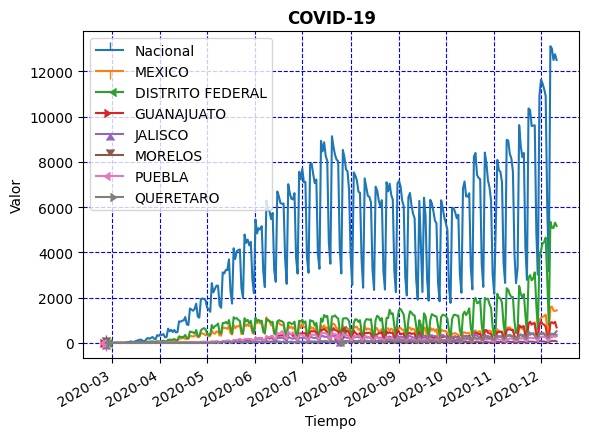

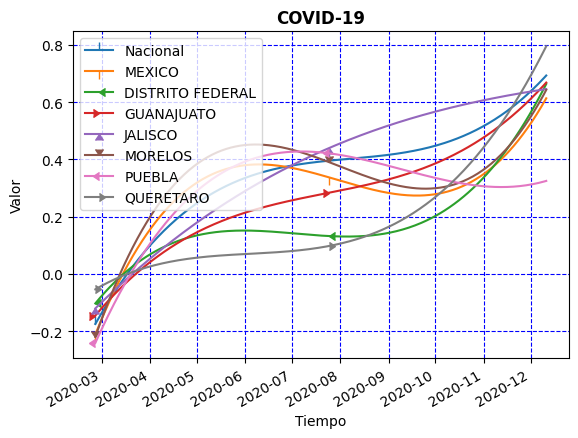

                 CORRELATION ANALYSIS
----------------------------------------------------------
                  Nacional    MEXICO  DISTRITO FEDERAL  GUANAJUATO   JALISCO  \
Nacional          1.000000  0.879905          0.846962    0.977791  0.963926   
MEXICO            0.879905  1.000000          0.773306    0.797412  0.727632   
DISTRITO FEDERAL  0.846962  0.773306          1.000000    0.906132  0.758837   
GUANAJUATO        0.977791  0.797412          0.906132    1.000000  0.963035   
JALISCO           0.963926  0.727632          0.758837    0.963035  1.000000   
MORELOS           0.818214  0.991266          0.691381    0.713531  0.649241   
PUEBLA            0.775409  0.837922          0.390842    0.627121  0.707866   
QUERETARO         0.797391  0.609155          0.965678    0.898229  0.771948   

                   MORELOS    PUEBLA  QUERETARO  
Nacional          0.818214  0.775409   0.797391  
MEXICO            0.991266  0.837922   0.609155  
DISTRITO FEDERAL  0.691381  0.39

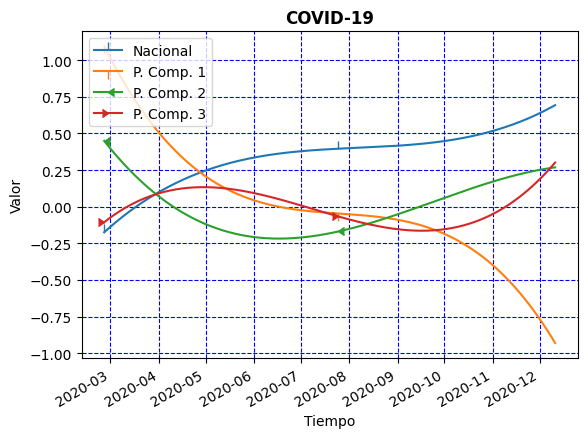



Fitting 5 folds for each of 196 candidates, totalling 980 fits
RF Estimated Parameters:
Best parameters found:  {'max_depth': 5, 'n_estimators': 3}
Best cross-validation score:  -1.6802051046928674


RF Parameters:
Number of trees (n_estimators): 3
Max depth of trees (max_depth): 5


Fitting 5 folds for each of 42 candidates, totalling 210 fits
SVM Estimated Parameters:
Best parameters found:  {'coef0': 1, 'degree': 3, 'kernel': 'poly'}
Best cross-validation score:  -40.31497144395735


                      MODEL PERFORMANCE COMPARISON
-----------------------------------------------------------------------
                      Training
-----------------------------------------------------------------------
Model Performance           RF          SVM
RSS                   0.002961     0.931559
SSR                   5.678854     3.605784
TSS                   5.681815     4.537344
R-Square              0.999479     0.794691
Adj. R-Square         0.999469     0.790817
AIC             

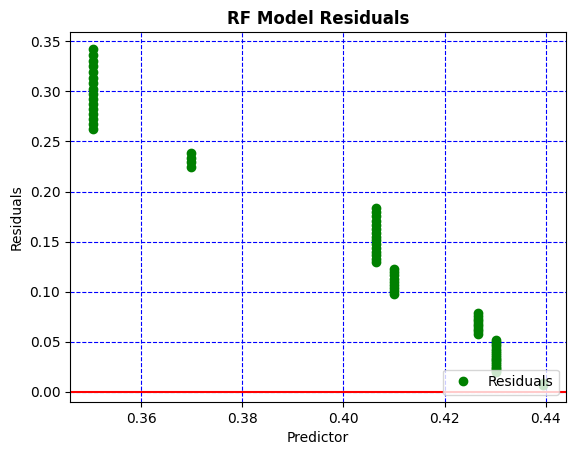

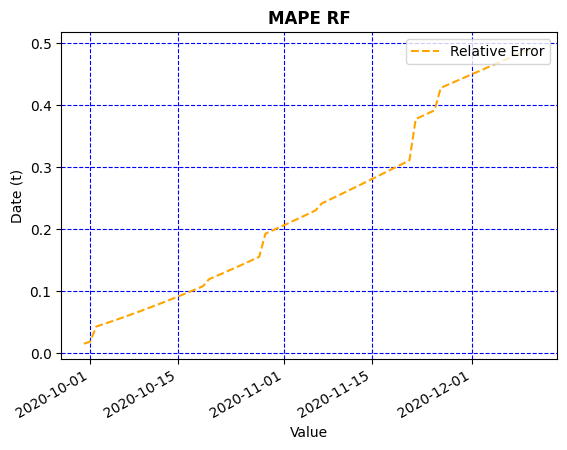

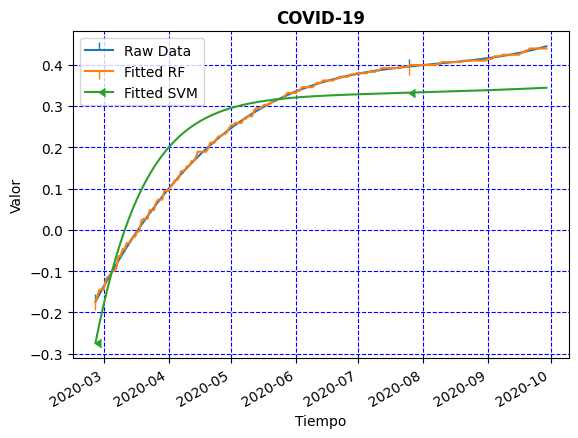

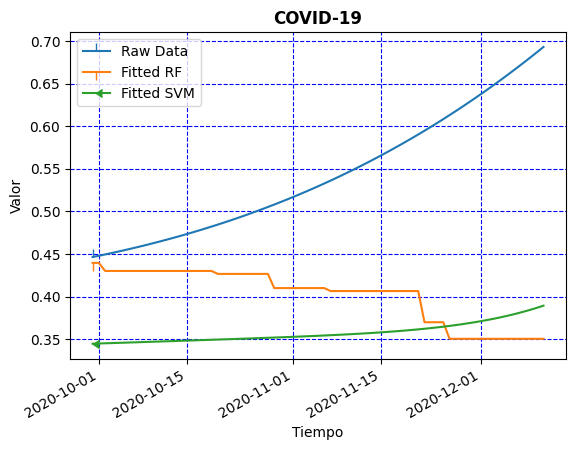

In [4]:
main()